### 说明
1. 主程序在最后，在每个函数底下都安排有测试代码或数据分析。由于程序主体全部封装在函数中，无需担心这些测试代码中变量的作用域问题
2. 主程序中不包含数据分析画图像的部分，数据分析部分分布在前面
3. 这部分内容看完了删掉即可

### 修改处
0. 这是我的本职工作：**加入了数据分析与图像**
1. 在三个类中加入了一些属性，主要是便利我数据分析
2. 优化掉了所有的copy与deepcopy，现在所有对于学生进入/移除小组，两个学生直接的交换，都是在真实的列表里进行。
3. 根据PEP 8 的编程规范，我将部分名称做出了修改
    - 类名使用驼峰命名法，函数名变量名使用下划线命名法
    - 全局变量名称字母全部大写，局部变量名称字母全部小写
    - 逗号分隔变量时，每个逗号后面要加空格
    - 注释的\#后面先打一个空格再开始写注释
    - ……
4. 将部分函数的功能拆分，使得每个函数现在的分工尽可能的明确
5. 将Group类的使用自始至终的贯彻到了贪心算法函数中
6. 适当调整了分数的计算方法，与退火的参数
7. 优化了其他条件，现在将运行时间由原来的1.4s优化到0.6s (在我的电脑上运行)


导入库

In [25]:
import random
import math
from collections import defaultdict
import csv
import matplotlib.pyplot as plt

GP_SIZE = 50

定义类

In [26]:
# 同学
class Student:
    def __init__(self, tutorial_group, student_id, school, name, gender, cgpa):
        self.tutorial_group = tutorial_group
        self.student_id = student_id
        self.school = school
        self.name = name
        self.gender = gender
        self.cgpa = float(cgpa)
        self.group_num = -1

# 小组 5人
class Group:
    def __init__(self, group_id):
        self.group_id = group_id # 建议两个类统一写
        self.groupmate = []
        self.score = 0
        self.male_ratio = 0
        self.school_ratio = {}
        self.avg_cgpa = 0
        self.size = 0
    
    def __str__(self):
        return f"{self.groupmate}"

# 大组 50人
class TutorialGroup:
    def __init__(self, group_id):
        self.group_id = group_id
        self.groupmate = []  # Student对象列表
        self.groups = {} # Groups 列表
        self.male_ratio = 0
        self.schools_ratio = {}
        self.avg_cgpa = 0
        self.cgpa_range = 0
        self.size = 0
        self.weights = {}    # 存放每组的熵权 {'School':x,'Gender':y,'CGPA':z}



In [27]:
# 计算每个小组的指标，方便分析初始数据
def calc_ratio(group:list):
    male_count = 0
    cgpas = []
    schools = {}
    size = len(group)
    for student in group:
        cgpas.append(student.cgpa)
        schools[student.school] = schools.get(student.school, 0) + 1
        male_count += student.gender == 'Male'
    male_ratio = male_count / size
    avg_cgpa = sum(cgpas) / size
    cgpa_range = max(cgpas) - min(cgpas)
    schools_ratio = {key: value / size for key, value in schools.items()}
    return male_ratio, schools_ratio, avg_cgpa, cgpa_range, size

def calc_ratio_groups(groups:dict):
    for group in groups.values():
        group.male_ratio, group.school_ratio, group.avg_cgpa, _, group.size = calc_ratio(group.groupmate)
    
def calc_ratio_dataset(dataset:dict):
    for tutorial_group in dataset.values():
        tutorial_group.male_ratio, tutorial_group.schools_ratio, tutorial_group.avg_cgpa, tutorial_group.cgpa_range, tutorial_group.size = calc_ratio(tutorial_group.groupmate)
    

In [28]:
# 读取文件
def read_csv(file_path:str)->dict:
    dataset = {}   # {组号: TutorialGroup 对象}
    with open(file_path, newline='', encoding='utf-8') as f: # 防止空行，保证格式正确
        reader = csv.DictReader(f) # 读取csv文件，并自动转成字典 
        for row in reader:
            
            new_student = Student(
                tutorial_group = row["Tutorial Group"],
                student_id = row["Student ID"],
                school = row["School"],
                name = row["Name"],
                gender = row["Gender"],
                cgpa = row["CGPA"], 
            )
            if new_student.tutorial_group not in dataset:# 存组号
                dataset[new_student.tutorial_group] = TutorialGroup(new_student.tutorial_group) # 创建组存组号     
            dataset[new_student.tutorial_group].groupmate.append(new_student) # 选组，找组员，添加
    calc_ratio_dataset(dataset)
    return dataset

In [29]:
dataset = read_csv("records.csv")
print(dataset['G-1'].schools_ratio)

{'CCDS': 0.1, 'EEE': 0.2, 'CoB (NBS)': 0.16, 'SoH': 0.1, 'WKW SCI': 0.04, 'CoE': 0.06, 'MAE': 0.08, 'SPMS': 0.04, 'SBS': 0.02, 'SSS': 0.1, 'ASE': 0.02, 'NIE': 0.02, 'ADM': 0.02, 'CCEB': 0.02, 'MSE': 0.02}


In [30]:
# 初始数据分析
# 对于所有小组，可视化性别分布，院校分布，成绩分布
# 以此说明，各组情况不同，因此应当具体情况具体分析，自然引出 权重 计算的必要性

# TODO: 太他妈丑了，图表亟待美化

# 计算一个叫做Gini Simpson Index的指标，这个指标可以反应院校的多样性。越接近0，院校越单一；越接近1，院校越多样
# 计算方法：对于每一大组，计算每个学院人数占总人数的比值, 然后求出这些比值的平方的和，最后用1减去
def calc_school_gini_simpson_index(tutorialgroup_schools_ratio:dict)->float:
    return 1 - sum(school_ratio**2 for school_ratio in tutorialgroup_schools_ratio.values())

# 计算cgpa的标准差
def calc_std_dev_cgpa(tutorialgroup:TutorialGroup)->float:
    avg_cgpa = tutorialgroup.avg_cgpa
    var_cgpa = sum((student.cgpa-avg_cgpa)**2 for student in tutorialgroup.groupmate) / tutorialgroup.size
    std_dev_cgpa = var_cgpa**0.5
    return std_dev_cgpa

# 画出每组男性比例的条形统计图，也可以同时画出女性比例的条形统计图
def plot_male_ratios(male_ratios:list):
    plt.figure(figsize=(10, 6))
    plt.hist(male_ratios, bins=10, edgecolor='black', color='red', alpha=0.7)
    plt.title('Distribution of Male Ratio Among 120 Tutorial Groups')
    plt.xlabel('Male Ratio')
    plt.ylabel('Number of Tutorial Groups')
    plt.grid(axis='y', linestyle='--')
    plt.show()

# 画出每组院校Gini Simpson Index的条形统计图
def plot_school_gini_simpson_indexs(school_gini_simpson_indexs:list):
    plt.figure(figsize=(10, 6))
    plt.hist(school_gini_simpson_indexs, bins=10, edgecolor='black', color='green', alpha=0.7)
    plt.title('Distribution of School Diversity Among 120 Tutorial Groups')
    plt.xlabel('Gini-Simpson Diversity Index (Higher means more diverse)')
    plt.ylabel('Number of Tutorial Groups')
    plt.grid(axis='y', linestyle='--')
    plt.show()

# 画出每组CGPA平均值与标准差的散点图
# 越往右代表小组成绩越优秀，越往上代表小组成绩越离散
def plot_cgpa_distribution(avg_cgpas:list, std_dev_cgpas:list):
    plt.figure(figsize=(10, 6))
    plt.scatter(avg_cgpas, std_dev_cgpas, color='blue', alpha=0.7)
    plt.title('Distribution of CGPA Among 120 Tutorial Groups')
    plt.xlabel('Average CGPA')
    plt.ylabel('Standard Deviation of CGPA (Higher means more diverse)')
    plt.grid(linestyle='--')
    plt.show()

# 画出这三幅图
def plot_distribution(dataset):
    male_ratios = [tutorialgroup.male_ratio for tutorialgroup in dataset.values()]
    school_gini_simpson_indexs = [calc_school_gini_simpson_index(tutorialgroup.schools_ratio) for tutorialgroup in dataset.values()]
    avg_cgpas = [tutorialgroup.avg_cgpa for tutorialgroup in dataset.values()]
    std_dev_cgpas = [calc_std_dev_cgpa(tutorialgroup) for tutorialgroup in dataset.values()]
    plot_male_ratios(male_ratios)
    plot_school_gini_simpson_indexs(school_gini_simpson_indexs)
    plot_cgpa_distribution(avg_cgpas, std_dev_cgpas)



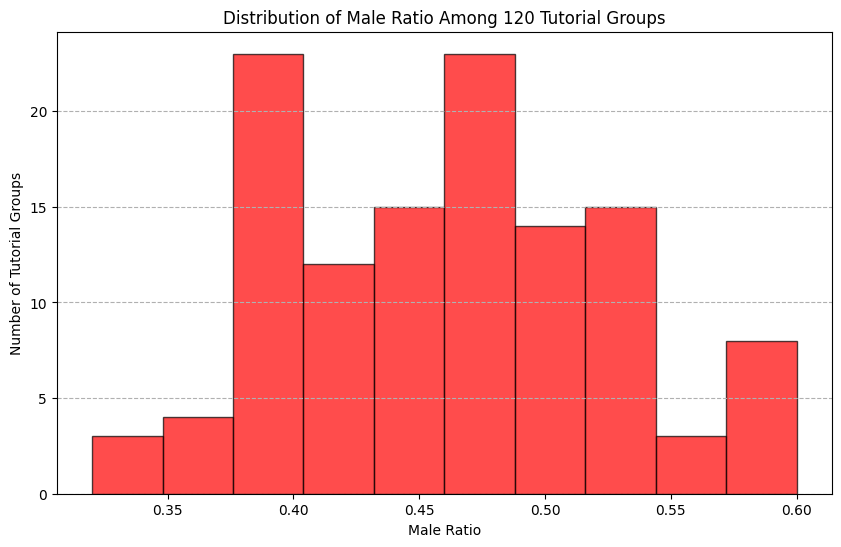

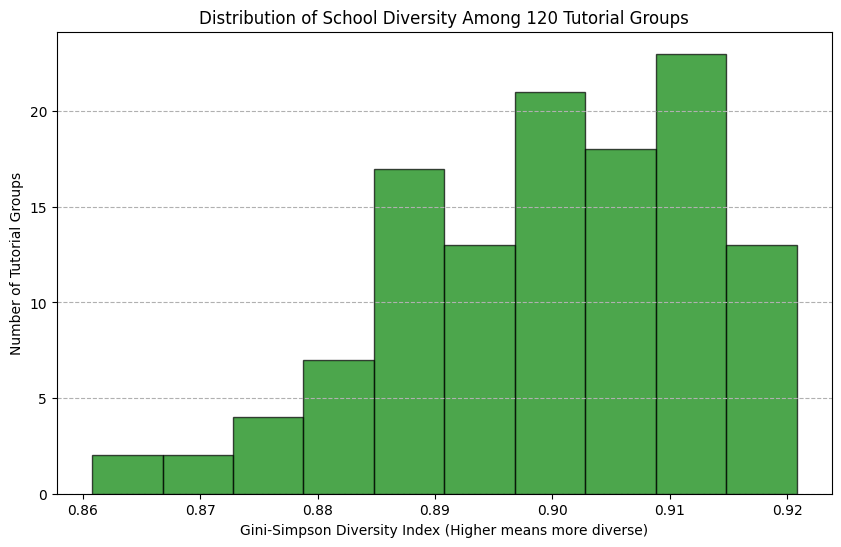

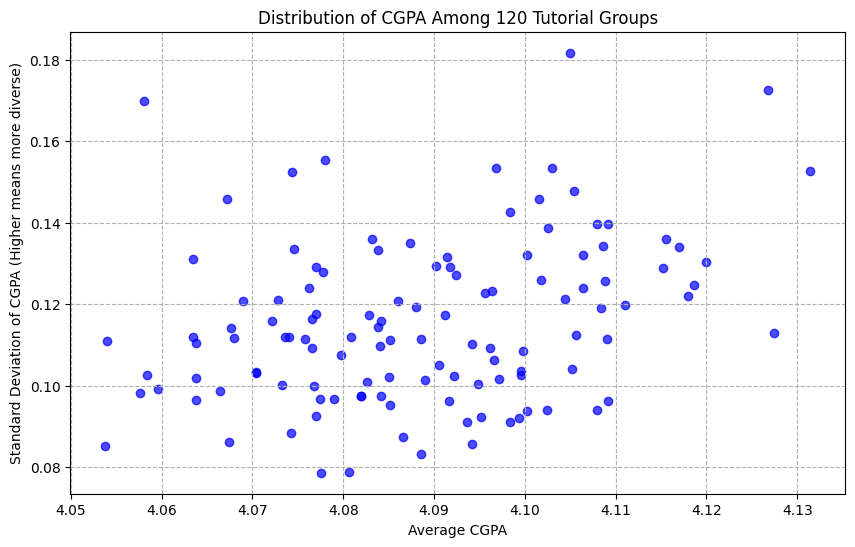

In [31]:
plot_distribution(dataset)

In [32]:
# 熵权法计算权重
# 标准化数据后，根据比例计算熵，根据熵的比例计算权重

def entropy_weight(data_matrix:list)->list:
    n = len(data_matrix) # 学生数量
    m = len(data_matrix[0]) # 指标数量
    norm = []
    for j in range(m):
        col = [data_matrix[i][j] for i in range(n)]
        min_val, max_val = min(col), max(col)
        norm_col = [(x - min_val) / (max_val - min_val + 1e-9) for x in col] 
        norm.append(norm_col) # 熵权法标准化
    norm_T = list(zip(*norm)) # 转置为每行单位为学生存放数据

    P = []  # 比例矩阵 P
    for j in range(m):
        col = [norm_T[i][j] for i in range(n)]
        col_sum = sum(col) + 1e-9 
        P.append([x / col_sum for x in col])

    E = [] # 熵 E
    for j in range(m):
        e = -sum([p * math.log(p + 1e-9) for p in P[j]]) / math.log(n)
        E.append(e)

    D = [1 - e for e in E] # 冗余度 D & 权重 W
    W = [d / sum(D) for d in D]
    return W

# 文字指标转换为数字计算权重
def encode_category(value:int, mapping_dict:dict)->int:
    if value not in mapping_dict:
        mapping_dict[value] = len(mapping_dict) + 1#编码
    return mapping_dict[value]

# 计算权重
def calc_weights(dataset:dict):
    school_map, gender_map = {}, {}
    for group_id, tg in dataset.items():
        data_matrix = []
        for student in tg.groupmate:
            school_code = encode_category(student.school, school_map)
            gender_code = encode_category(student.gender, gender_map)
            cgpa_value = student.cgpa
            data_matrix.append([school_code, gender_code, cgpa_value]) # 文字指标转数字
        weights = entropy_weight(data_matrix)
        tg.weights = {"School": weights[0],"Gender": weights[1],"CGPA": weights[2]}

In [33]:
calc_weights(dataset)
print(dataset['G-1'].weights)

{'School': 0.3682010086876191, 'Gender': 0.5105196722607507, 'CGPA': 0.1212793190516302}


贪心算法部分

伪代码: 
# 这块要改一改啊，比如把quanzhong换成weights，还有一些修改的代码没有更新
```  
FUNCTION calc_score_v1(the list of 5 student, which tutorial group are they from):  
    quanzhong = the previous calculated weights
    
    calculate the gender_score:
        iterate through the members of the five_person group and find the current number of males
        calculate the current proportion of males in the five-person group
        iterate through the members of the tutorial group and find the current number of males
        calculate the current proportion of males in the tutorial group
        the gender_score = the absolute value of proportion's differnce

    calculate the school_diversity:
        find the current number of schools of the group
        find the current number of student of the group
        school_diversity = 1-school_number/student_number

    caculate the cgpa_score:
        calculate the average cgpa of the tutorial group
        calculate the average cgpa of the group
        cgpa_score = the absolute value of (average_cgpa_in_group - average_cgpa_in_tutorialgroup)

    caculate the score:
        score = gender_score*the_weight_of_gender_score + school_diversity*the_weight_of_school_diversity + cgpa_score*the_weigh_of_cgpa_score
```

In [34]:
# 算分, 这里我做出了修改，使用Gini Simpson Index来反应院校多样性
def calc_score(given_list, tutorialgroup:TutorialGroup, method="entropy"):
    if not given_list:
        return 0
    
    # 使用熵权法和自定义权重法，两种方法可以对比，来体现熵权法的优越性
    if method == "entropy":
        weights = tutorialgroup.weights
    else:
        weights = {'Gender': 0.3, 'School':0.4, 'CGPA':0.3} # 可以自定义一个，这里临时写上
    
    cur_male_ratio, cur_schools_ratio, cur_avg_cgpa, cur_cgpa_range, cur_size = calc_ratio(given_list)
    raw_gender_score = abs(cur_male_ratio - tutorialgroup.male_ratio)
    raw_school_score = calc_school_gini_simpson_index(cur_schools_ratio)
    raw_cgpa_score = abs(cur_avg_cgpa - tutorialgroup.avg_cgpa)
    # print("------Raw Score------")
    # print(raw_gender_score, raw_school_score, raw_cgpa_score)

    # 为了确保各个分数的影响力只由权重决定，对分数进行归一化操作，使得所有分数的范围都落在[0,1]之间
    min_school_score = 1 / cur_size
    norm_school_score = (raw_school_score - min_school_score) / ((1 - min_school_score) + 1e-9)
    norm_cgpa_score = raw_cgpa_score / (tutorialgroup.cgpa_range + 1e-9)
    norm_gender_score = raw_gender_score
    # print("------Normal Score------")
    # print(norm_gender_score, norm_school_score, norm_cgpa_score)

    # 乘以权重，得到最终得分
    final_gender_score = norm_gender_score * weights['Gender'] 
    final_school_score = norm_school_score * weights['School']
    final_cgpa_score = norm_cgpa_score * weights['CGPA']
    # print("------Final Score------")
    # print(final_gender_score,  final_school_score, final_cgpa_score)
    # print("------Sum------")
    score = final_gender_score + final_school_score + final_cgpa_score
    return score

In [35]:
gp = dataset["G-1"]
random_student = random.sample(gp.groupmate, 5)
print([st.gender for st in random_student], gp.male_ratio)
print([st.school for st in random_student])
print([st.cgpa for st in random_student], gp.avg_cgpa)
score = calc_score(random_student, gp)
print(score)

['Female', 'Male', 'Male', 'Female', 'Female'] 0.42
['SSS', 'NIE', 'EEE', 'CoB (NBS)', 'CCDS']
[3.88, 3.85, 4.03, 4.26, 4.08] 4.0956
0.3000458011181566


In [36]:
# 建议把number_of_groups 先写死成全局变量 GP_NUM, 日后如需要交互式输入再修改
# 进行稀有度分层
def hierarchical_grouping(gp:list):
    # 创建分层分组字典stratified_groups，格式:{('学院','性别'):[student1,student2,......],......}
    stratified_groups = defaultdict(list)
    for student in gp:
        key = (student.school, student.gender)
        stratified_groups[key].append(student)
    # 每一层按成绩从高到低排序
    for key in stratified_groups:
        stratified_groups[key].sort(key=lambda x: x.cgpa, reverse=True)
    # 开始按稀有度分组
    sorted_layers = sorted(stratified_groups.items(), key=lambda x:len(x[1])) #此处x：(('学院','性别'),[student1,student2,...])；按稀有度排序
    return sorted_layers

def allocate_first_student(groups:dict[int:Group], sorted_layers, number_of_groups)->int:
    count = 0 # 记录分了几个人
    # 为每个小组分配第一个人
    for layer_key, students in sorted_layers:
        if count >= number_of_groups:
            break
        if students: #该层非空：
            target = min(groups.keys(), key=lambda x: len(groups[x].groupmate)) # 寻找空的组，获取其编号
            target_student = students.pop(0) # 从该层中拿走成绩最好的学生
            # stratified_groups[layer_key].remove(target_student)
            target_student.group_num = target # 该学生的组号就是当前小组
            groups[target].groupmate.append(target_student) # 将该学生加入小组
            count += 1
            # print(f"将层级{layer_key}的学生分到第{target}组")
    return count

def stratified_grouping(tutorialgroup:TutorialGroup, group_size:int, number_of_groups:int, method="entropy"):
    tutorialgroup_students = tutorialgroup.groupmate # 格式：[student1,student2,......,student50]
    groups = {i: Group(i) for i in range(1, number_of_groups+1)} # 储存分组结果的字典

    # 分层并为每组分配第一个同学, 同时记录已经分配的人数
    sorted_layers = hierarchical_grouping(tutorialgroup_students)
    count = allocate_first_student(groups, sorted_layers, number_of_groups)
    # 更新分数
    for i in range(1, number_of_groups+1):
        groups[i].score = calc_score(groups[i].groupmate, tutorialgroup, method)

    for student in tutorialgroup_students:
        # 对于已经分好组的同学，直接跳过
        if student.group_num != -1:
            continue
        best_group = None
        lowest_score_increase = float('inf') # 计算分数增加的最小值 这个数的来源是什么？如果是要一个很大的数可以用
        best_group_score = None
        full = True # 通过布尔值记录是否所有小组已满，因为前面记录小组数量的时候只取整数而没考虑余数，对于不能整除的情况会剩下一些未分配的同学

        for i in range(1, number_of_groups+1):
            cur_group = groups[i]
            if len(cur_group.groupmate) >= group_size:
                continue
            full = False
            #生成临时小组，计算分数增加量
            previous_score = groups[i].score
            
            cur_group.groupmate.append(student)
            current_score = calc_score(cur_group.groupmate, tutorialgroup, method)
            score_increase = current_score - previous_score
            cur_group.groupmate.pop()
            if score_increase < lowest_score_increase:
                lowest_score_increase = score_increase
                best_group = i
                best_group_score = current_score
        if not full:
            student.group_num = best_group
            groups[best_group].score = best_group_score
            groups[best_group].groupmate.append(student)
        count += 1
    
    # 循环结束后，如果恰好分配完，那么full就是False. 反之如果有剩余，那么full就是True
    # 处理剩下未分配的同学
    if full: 
        randomlist = random.sample(range(1, number_of_groups+1), tutorialgroup.size-count)
        for i in range(count, tutorialgroup.size):
            cur_group = groups[randomlist[i-count]]
            student = tutorialgroup_students[i]
            student.group_num = randomlist[i-count]
            cur_group.groupmate.append(student)
            cur_group.score = calc_score(cur_group.groupmate, tutorialgroup, method)
    
    calc_ratio_groups(groups)
    tutorialgroup.groups = groups

In [37]:
dataset = read_csv("records.csv")
calc_weights(dataset)
tg = dataset["G-1"]
stratified_grouping(tg, group_size=4, number_of_groups=12)

for key, group in tg.groups.items():
    print('-'*10 + 'Group' + str(key) + '-'*10)
    print(f"Male ratio: {group.male_ratio}")
    print(f"School ratio: {group.school_ratio}")
    print(f"Average CGPA: {group.avg_cgpa:.2f}")
    print(f'Group score: {group.score:.2f}')
    # print(f'{[(st.gender, st.school) for st in group.groupmate]} {group.score}')

----------Group1----------
Male ratio: 0.25
School ratio: {'WKW SCI': 0.25, 'EEE': 0.25, 'SPMS': 0.25, 'SSS': 0.25}
Average CGPA: 4.16
Group score: 0.34
----------Group2----------
Male ratio: 0.5
School ratio: {'WKW SCI': 0.25, 'SSS': 0.5, 'MAE': 0.25}
Average CGPA: 4.12
Group score: 0.23
----------Group3----------
Male ratio: 0.5
School ratio: {'SBS': 0.25, 'EEE': 0.25, 'CoB (NBS)': 0.25, 'MAE': 0.25}
Average CGPA: 4.05
Group score: 0.29
----------Group4----------
Male ratio: 0.5
School ratio: {'ASE': 0.25, 'CoB (NBS)': 0.25, 'CCDS': 0.25, 'SoH': 0.25}
Average CGPA: 4.21
Group score: 0.31
----------Group5----------
Male ratio: 0.25
School ratio: {'CoE': 0.25, 'EEE': 0.25, 'CCDS': 0.25, 'CoB (NBS)': 0.25}
Average CGPA: 4.09
Group score: 0.33
----------Group6----------
Male ratio: 0.5
School ratio: {'NIE': 0.25, 'EEE': 0.25, 'CoB (NBS)': 0.5}
Average CGPA: 4.04
Group score: 0.24
----------Group7----------
Male ratio: 0.25
School ratio: {'ADM': 0.25, 'EEE': 0.25, 'MAE': 0.25, 'SSS': 0.25

In [38]:
# 画小组男性比例
def plot_group_male_ratio(axis, group_labels, male_ratios, gp_male_ratio):
    axis.bar(group_labels, male_ratios, color='skyblue')
    axis.axhline(y=gp_male_ratio, color='red', linestyle='--', label=f'Group Male Ratio = {gp_male_ratio}')
    axis.set_title('Male Ratio')
    axis.set_ylim(0, 1)
    axis.set_ylabel('Male Ratio')
    axis.legend()
    axis.grid(axis='y', linestyle='--', alpha=0.7)  

# 画小组院校数量
def plot_group_school_ratio(axis, group_labels, school_ratios):
    unique_school_counts = [len(school_ratio) for school_ratio in school_ratios]
    axis.bar(group_labels, unique_school_counts, color='green')
    axis.set_title('School Diversity')
    axis.set_ylim(max(0, min(unique_school_counts)-2), max(unique_school_counts)+1)
    axis.set_ylabel('Number of Unique Schools')
    axis.grid(axis='y', linestyle='--', alpha=0.7)

# 画小组平均CGPA
def plot_group_cgpa(axis, group_labels, avg_cgpas, gp_avg_cgpa):
    axis.bar(group_labels, avg_cgpas, color='salmon')
    axis.axhline(y=gp_avg_cgpa, color='red', linestyle='--', label=f'Group Average CGPA = {gp_avg_cgpa:.2f}')
    axis.set_title('Average CGPA')
    axis.set_ylim(min(avg_cgpas) * 0.95, max(avg_cgpas) * 1.05)
    axis.set_ylabel('Average CGPA')
    axis.legend()
    axis.grid(axis='y', linestyle='--', alpha=0.7)

def plot_group_distribution(tutorialgroup:TutorialGroup, title="Greedy Algorithm Result"):
    groups = tutorialgroup.groups
    tutorialgroup_id = tutorialgroup.group_id
    group_labels = [str(i) for i in groups.keys()]

    figsize_width = max(15, len(groups)*1.2) 
    fig, axes = plt.subplots(1, 3, figsize=(figsize_width, 6))
    fig.suptitle(f'{title} for {tutorialgroup_id}', fontsize=20)

    male_ratios = [group.male_ratio for group in groups.values()]
    school_ratios = [group.school_ratio for group in groups.values()]
    avg_cgpas = [group.avg_cgpa for group in groups.values()]
    gp_male_ratio = tutorialgroup.male_ratio
    gp_avg_cgpa = tutorialgroup.avg_cgpa

    plot_group_male_ratio(axes[0], group_labels, male_ratios, gp_male_ratio)
    plot_group_school_ratio(axes[1], group_labels, school_ratios)
    plot_group_cgpa(axes[2], group_labels, avg_cgpas, gp_avg_cgpa)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

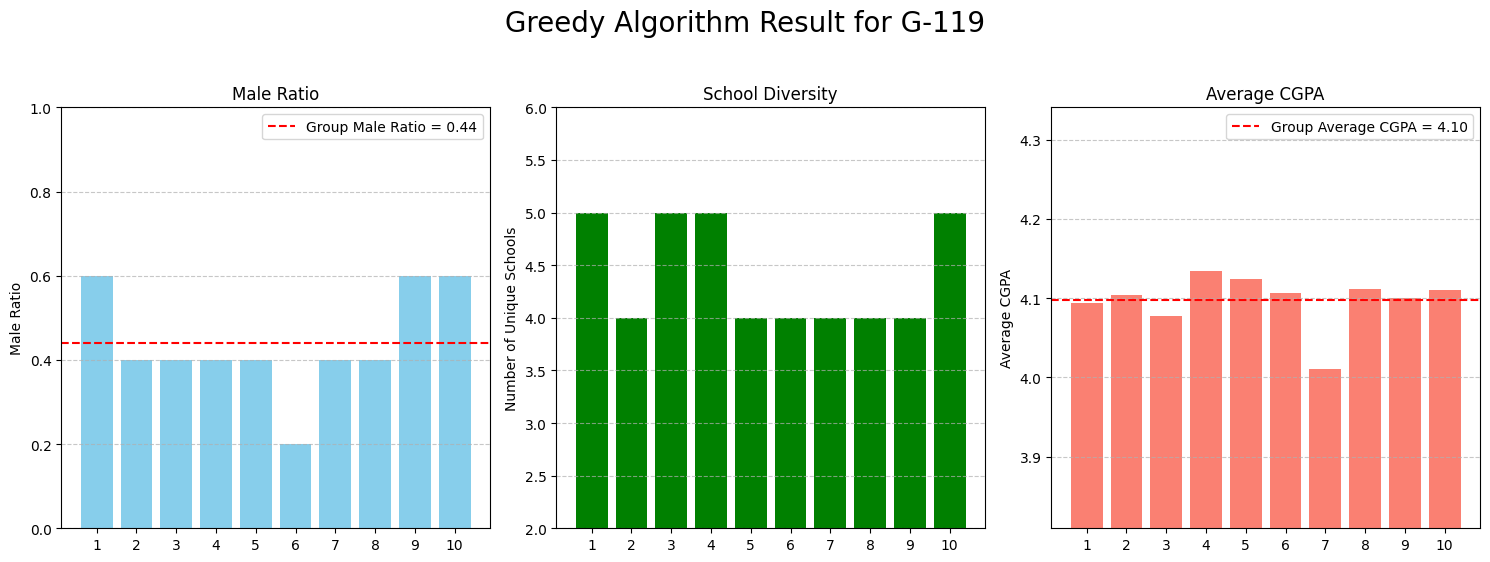

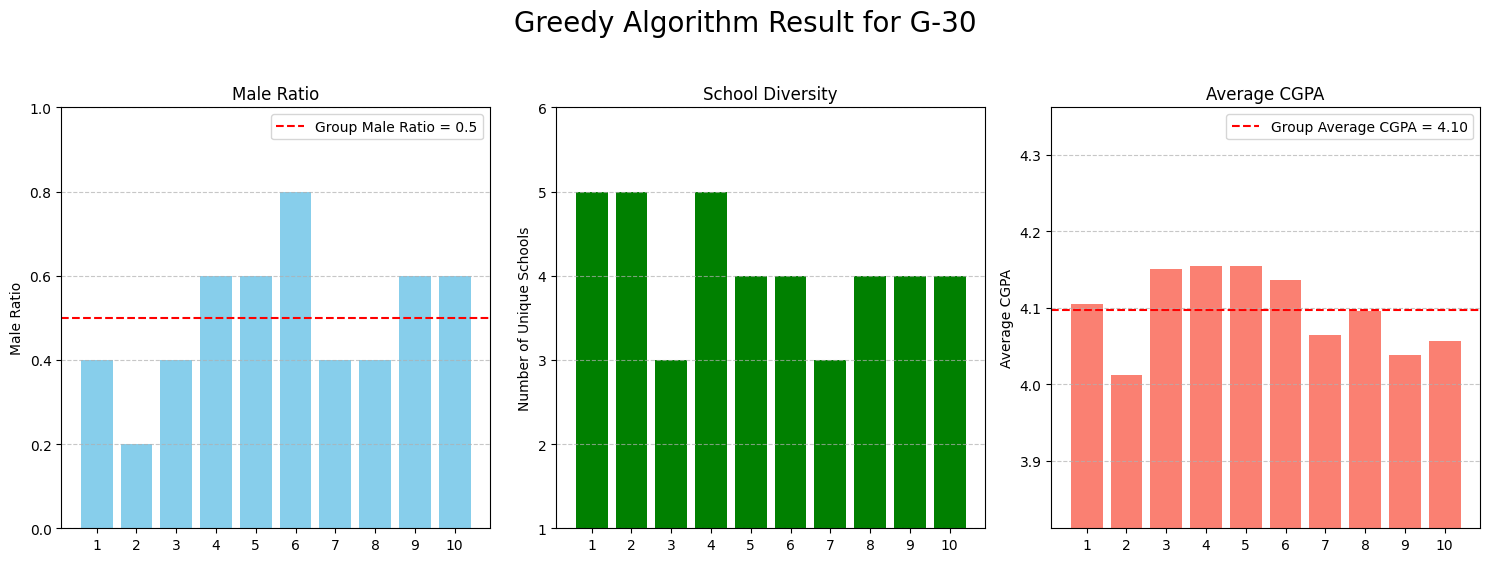

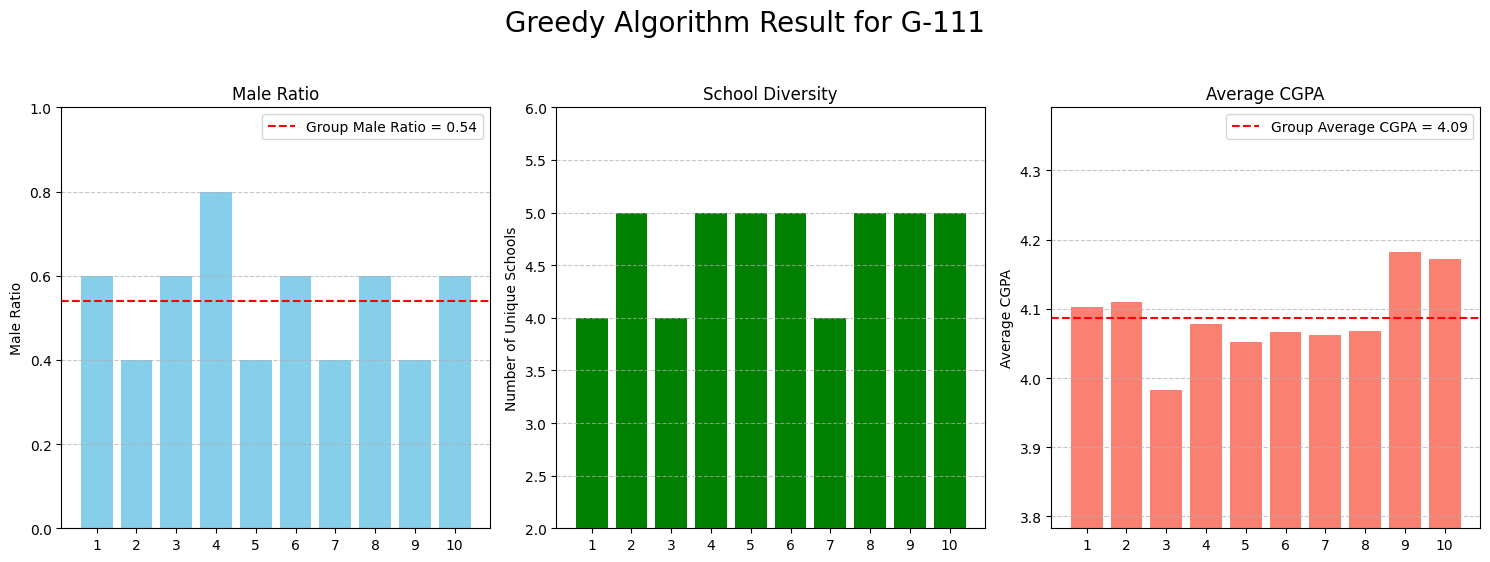

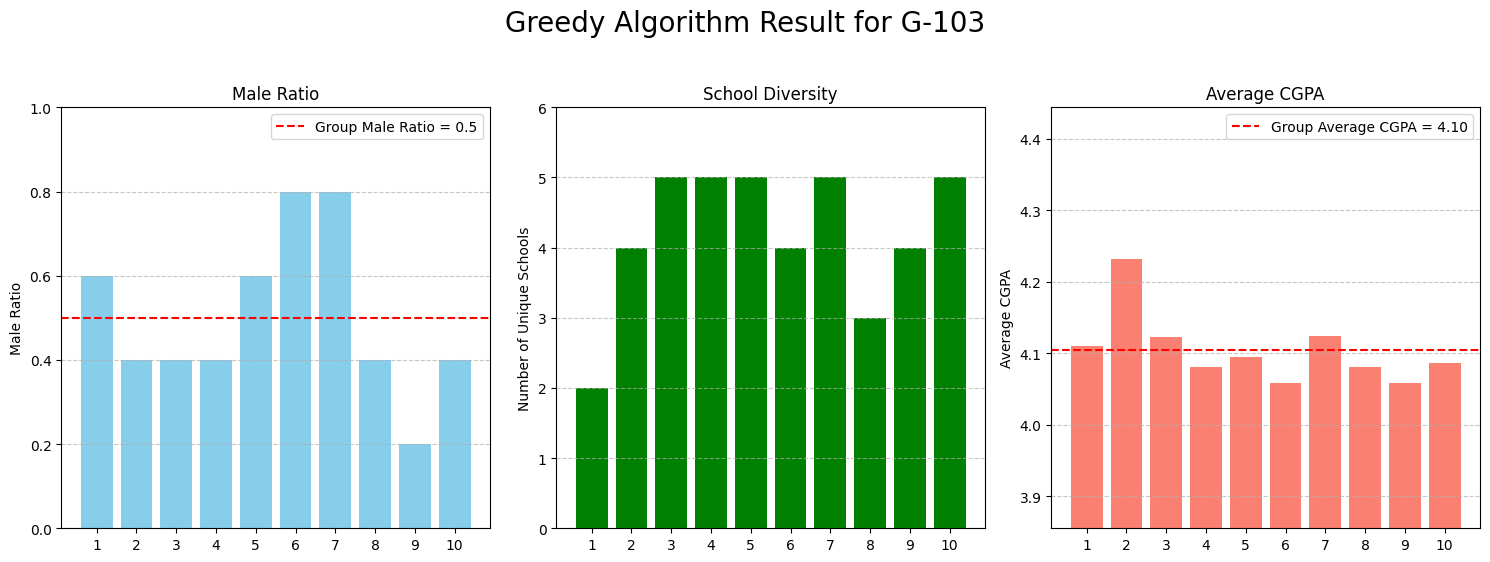

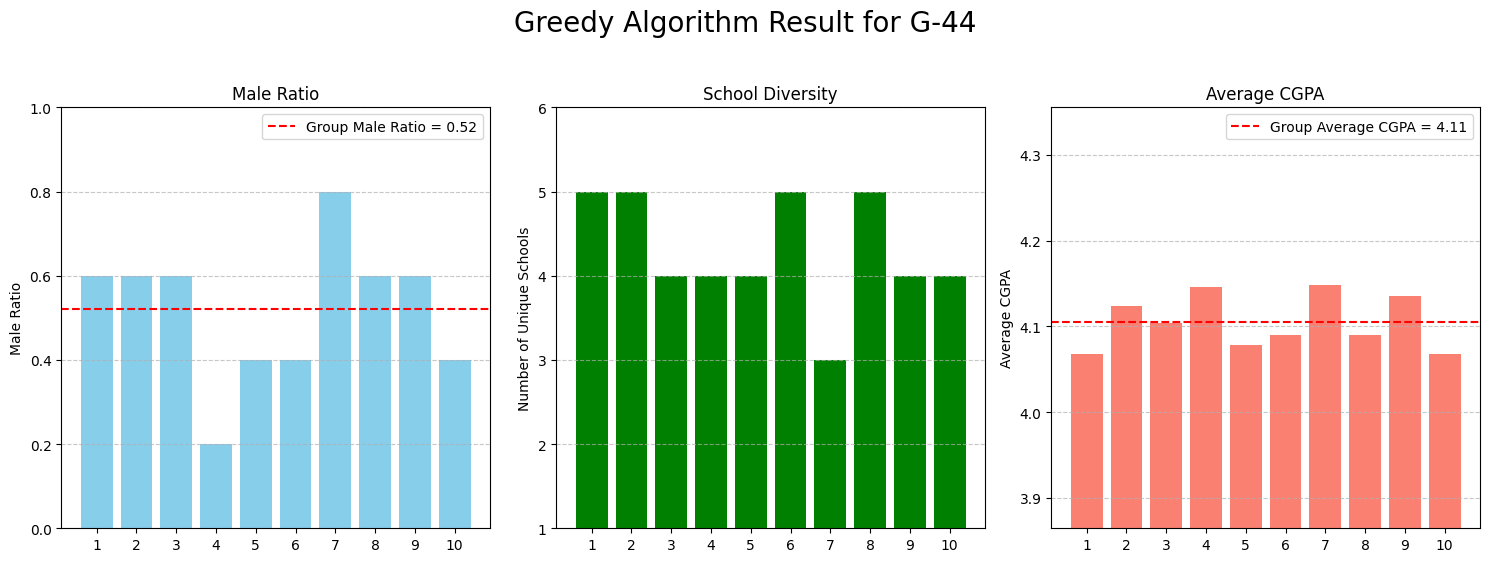

In [39]:
dataset = read_csv("records.csv")
calc_weights(dataset)
tg_list = [t for t in dataset.values()]
random_tg = random.sample(tg_list, 5)
for tg in random_tg:
    stratified_grouping(tg, group_size=5, number_of_groups=10)
    plot_group_distribution(tg)

交换退火

交换函数

伪代码：  
FUNCTION exchange_two(groups):  
    ID1,ID2 = randomly choose 2 groups from group  
    pick1 = selected group1  
    pick2 = selected group2  
    student1,student2 = randomly choose 1 student from each selected group  
    exchange student1 and student2  
    RETURN pick1,pick2,student1,student2

In [40]:
def select_two(cur_groups:dict[int:Group]):
    # 随机选取两个组
    groups = [gp for gp in cur_groups.values()]
    group1, group2 = random.sample(groups, 2)  
    # 每组分别随机选取一个学生
    student_idx1 = random.randint(0, len(group1.groupmate)-1)
    student_idx2 = random.randint(0, len(group2.groupmate)-1) 
    return group1, group2, student_idx1, student_idx2

def exchange_two(group1:Group, group2:Group, student_idx1:int, student_idx2:int):
    group1.groupmate[student_idx1],group2.groupmate[student_idx2] = group2.groupmate[student_idx2],group1.groupmate[student_idx1] # 交换两个人

计算交换后的分数

判断是否接受

伪代码:
FUNCTION accept_change(delta,temperature):  
    IF delta > 0:
        RETURN True
    ELSE:
        sta = exp(delta/temperature)
        IF:
            random_value < sta
                RETURN TRUE
        ElSE:
            RETURN False            

In [41]:
def accept_change(delta,temperature):  #delta和temperature在后面退火的函数再说，delta就是分数差
    if delta > 0:
        return True   #交换后变好，直接接受
    else:
        sta = math.exp(delta/temperature)
        return random.random() < sta   #变坏后有一定几率接受

退火主函数

伪代码：  
```
FUNCTION annealing(groups,tutorialgroup_id,initial_temp=100 (#initial temperature),cooling_rate=0.99 (#the speed of cooling),min_tem (#min temperature,when temperature<min_temperature,break),max_iter=1000 (#it can iterate at most 1000 times)):  
    current_groups = copy_of_groups
    current_score = the_group_score_obtained_from_the_previous_process  
    initialize temperature = 0  
    initialize iteration = 0  
    initialize the num of consecutive exchanges that are all not accepted = 0  
    WHILE temperature is not below min_tem AND iteration has not exceeded max_iter:  
        iteration = iteration+1  
        initialize new_groups = current_groups  
        initialize new_score = current_score  
        use exchange_two to exchange two student  
        calculate new_score of the tutorial group  
        caculate the score difference before and after  
        IF change is accepted:  
            current_groups = new_groups  
            currrent_score = new_score  
            let no_change_count = 0 again
        ELSE:  
            no_change_count = no_change_count +1   
    temperature cool down  
    RETURN current_groups,current_score    
```  

In [42]:
# 最低温度和最高循环次数有一些冲突吧
def annealing(tutorialgroup:TutorialGroup, number_of_groups, initial_temp=100, cooling_rate=0.99, min_temp=0.01, max_iter=1000, max_no_change=100, method="entropy"):  #这些都是自己定义的数据，后面商量一下定位多少
    temperature = initial_temp
    iteration = 0  # 计算迭代次数
    no_change_count = 0  # 计算连续交换后都不接受的情况发生的次数
    
    while temperature > min_temp and iteration < max_iter and no_change_count < max_no_change:
        iteration += 1
        group1, group2, student_idx1, student_idx2 = select_two(tutorialgroup.groups)
        
        # 记录交换前的分数
        previous_score_1 = group1.score
        previous_score_2 = group2.score
        previous_score = previous_score_1 + previous_score_2
        # 交换
        exchange_two(group1, group2, student_idx1, student_idx2) # 交换
        # 记录交换后的分数
        cur_score_1 = calc_score(group1.groupmate, tutorialgroup, method)
        cur_score_2 = calc_score(group2.groupmate, tutorialgroup, method)
        new_score = cur_score_1 + cur_score_2
        delta = previous_score - new_score  # 计算调换后的分数与原来分数之差
        if accept_change(delta, temperature):
            no_change_count = 0 # 因为是连续不接受，所以一旦接受就重新变成0
            # 更新交换后小组的分数
            group1.score, group2.score = cur_score_1, cur_score_2
        else:
            no_change_count += 1
            # 交换失败，再把他们换回来
            exchange_two(group1, group2, student_idx1, student_idx2)
        temperature *= cooling_rate  # 每次循环后降温一次
    calc_ratio_groups(tutorialgroup.groups)

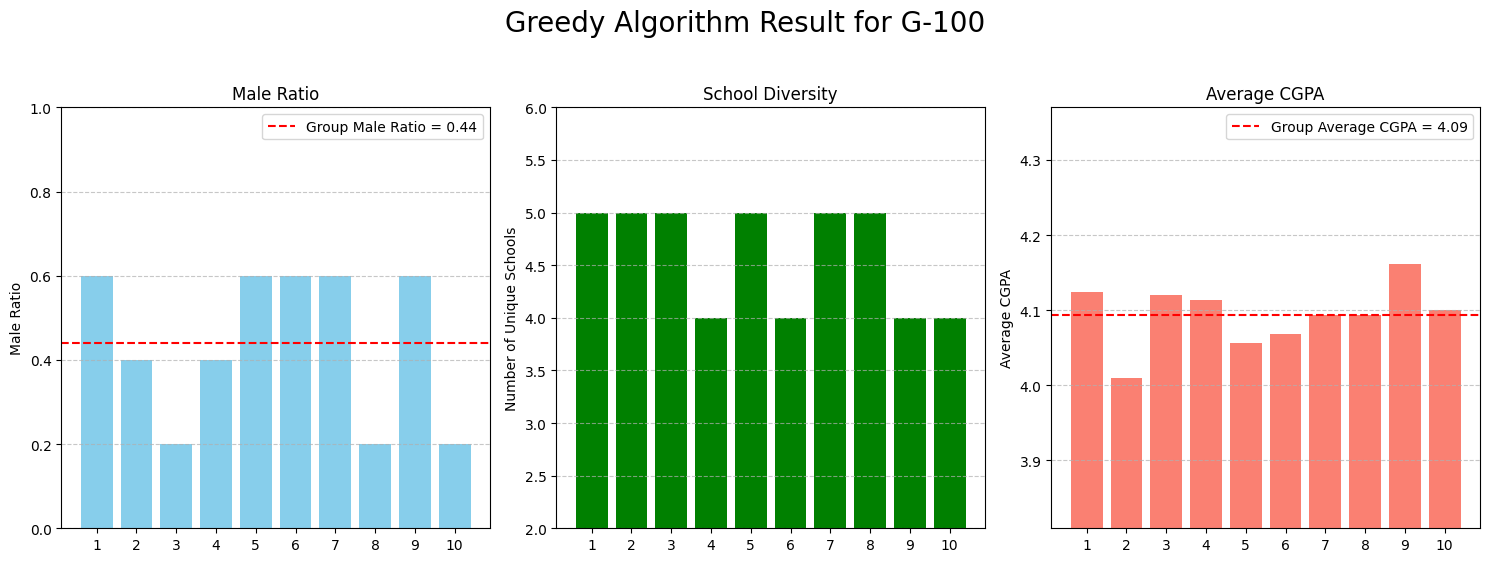

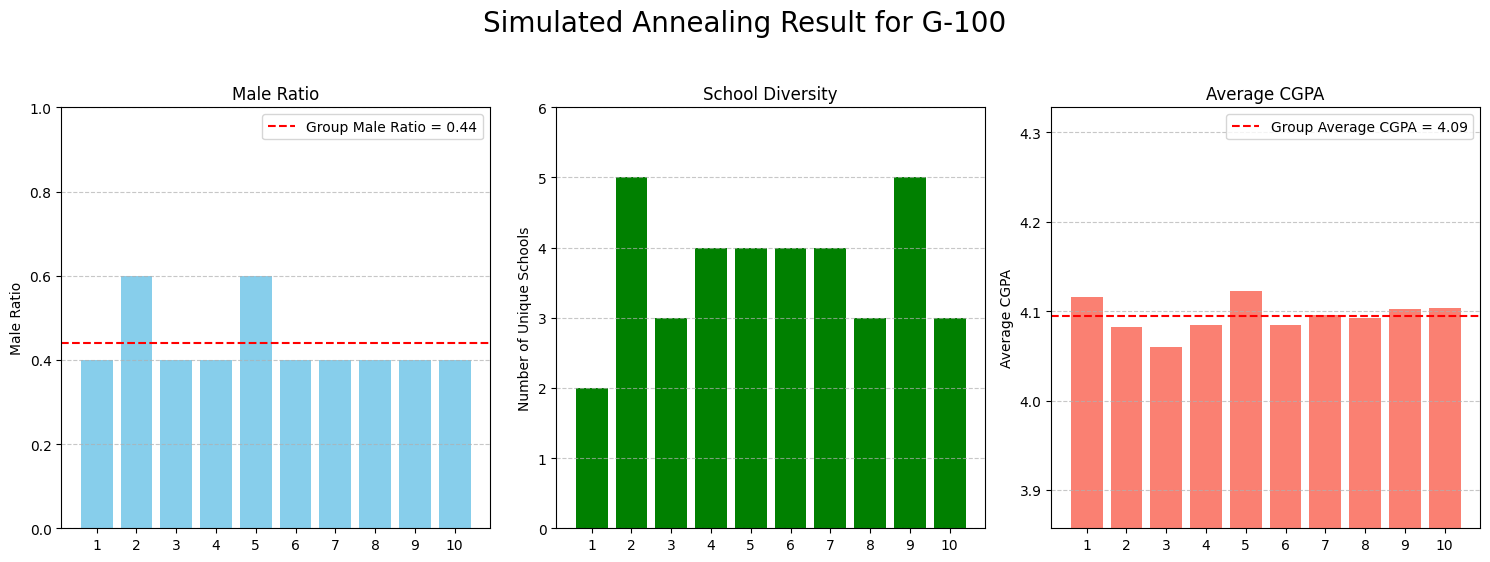

In [43]:
dataset = read_csv("records.csv")
calc_weights(dataset)
tg = dataset["G-100"]
stratified_grouping(tg, group_size=5, number_of_groups=10,method="")
plot_group_distribution(tg)
annealing(
    tutorialgroup = tg, 
    number_of_groups = 10, 
    initial_temp = 100, 
    cooling_rate = 0.99, 
    min_temp = 0.01, 
    max_iter = 1000, 
    max_no_change = 100,
    method = ""
    )
plot_group_distribution(tg, title="Simulated Annealing Result")

In [44]:
def allocation(dataset, group_size:int, number_of_groups:int, method="entropy",initial_temp=100, cooling_rate=0.99, min_temp=0.01, max_iter=1000, max_no_change=100):
    for gp_id, tutorialgroup in dataset.items():
        
        stratified_grouping(
            tutorialgroup = tutorialgroup, 
            group_size = group_size, 
            number_of_groups = number_of_groups, 
            method = method
            )
        
        annealing(
            tutorialgroup = tutorialgroup, 
            number_of_groups = number_of_groups, 
            initial_temp = initial_temp, 
            cooling_rate = cooling_rate, 
            min_temp = min_temp, 
            max_iter = max_iter, 
            max_no_change = max_no_change, 
            method = method
            )
        print(f"{gp_id} has completed its grouping.")

In [45]:
def ask_for_input(use_defalut_value=True):
    if use_defalut_value:
        return 5, 10
    valid_input = False
    group_size = 0
    while not (4 <= group_size <= 10) or not valid_input:
        try:
            print("Please enter the Group size: ")
            group_size = int(input())
            valid_input = True
            if not (4 <= group_size <= 10):
                print("Invalid Input. Please enter a integer between 4 and 10.")
        except:
            print("Invalid Input. Please enter a integer between 4 and 10.")
    number_of_groups = GP_SIZE // group_size
    return group_size, number_of_groups

In [46]:
def write_csv(dataset):
    with open("output.csv","w",newline = '',encoding="utf-8") as f:
        writer = csv.writer(f)
        header = ['Tutorial Group', 'Group', 'Student ID', 'School', 'Name', 'Gender', 'CGPA']
        writer.writerow(header)
        for tutorialgroup_id, tutorialgroup in dataset.items():
            for student in tutorialgroup.groupmate:
                row = [tutorialgroup_id, student.group_num, student.student_id, student.school, student.name, student.gender, student.cgpa]
                writer.writerow(row)

主程序

In [47]:
def main():
    group_size, number_of_groups = ask_for_input()
    dataset = read_csv("records.csv")
    calc_weights(dataset)
    allocation(
        dataset = dataset, 
        group_size = group_size, 
        number_of_groups = number_of_groups, 
        method = "entropy",
        initial_temp = 100, 
        cooling_rate = 0.99, 
        min_temp = 0.01, 
        max_iter = 1000, 
        max_no_change = 100,
        )
    write_csv(dataset)
    print("Finished!")

In [48]:
main()

G-1 has completed its grouping.
G-10 has completed its grouping.
G-100 has completed its grouping.
G-101 has completed its grouping.
G-102 has completed its grouping.
G-103 has completed its grouping.
G-104 has completed its grouping.
G-105 has completed its grouping.
G-106 has completed its grouping.
G-107 has completed its grouping.
G-108 has completed its grouping.
G-109 has completed its grouping.
G-11 has completed its grouping.
G-110 has completed its grouping.
G-111 has completed its grouping.
G-112 has completed its grouping.
G-113 has completed its grouping.
G-114 has completed its grouping.
G-115 has completed its grouping.
G-116 has completed its grouping.
G-117 has completed its grouping.
G-118 has completed its grouping.
G-119 has completed its grouping.
G-12 has completed its grouping.
G-120 has completed its grouping.
G-13 has completed its grouping.
G-14 has completed its grouping.
G-15 has completed its grouping.
G-16 has completed its grouping.
G-17 has completed its 